# An overview of Deep Learning models

In this document, I present a high-level overview of common Deep-Learning models. The word 'model' does not imply a specific approach to prediction. Rather, it is used to indicate a particular configuration for network units. In that sense, 'model' is closer to 'architecture' or 'set-up.'  
### Basic Feedforward Network used for Word2Vec generation ###
We've already reviewed Word2Vec extensively, but here's a brief recap. Below is a schema for the standard single-hidden-layer **CBOW** model. Errors are often calculated as the KL divergence between predicted and observed y values, and backpropagated through the layers.

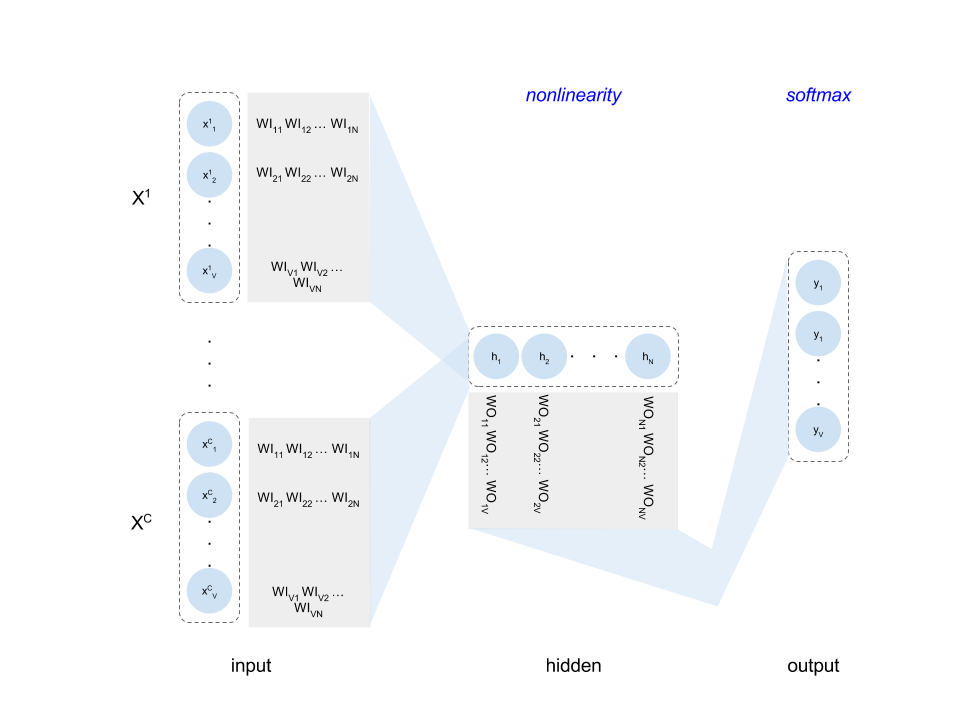

In [1]:
from IPython.display import Image
Image(filename='images/feedforward.png')

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Word count [('cats', 10), ('dogs', 6), ('and', 5), ('are', 4), ('love', 3)]
Sample data [5, 14, 30, 27, 21, 15, 5, 9, 19, 29] ['the', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog', 'I']
Context pairs [[[5, 30], 14], [[14, 27], 30], [[30, 21], 27], [[27, 15], 21], [[21, 5], 15], [[15, 9], 5], [[5, 19], 9], [[9, 29], 19], [[19, 4], 29], [[29, 0], 4]]
skip-gram pairs [[14, 5], [14, 30], [30, 14], [30, 27], [27, 30]]
Batches (x, y) ([24, 8, 1], [[18], [23], [3]])
Loss at  0 21.6122
Loss at  10 11.2493
Loss at  20 5.72732
Loss at  30 4.02467
Loss at  40 3.43711
Loss at  50 3.27991
Loss at  60 3.27771
Loss at  70 2.97411
Loss at  80 3.47828
Loss at  90 3.33501


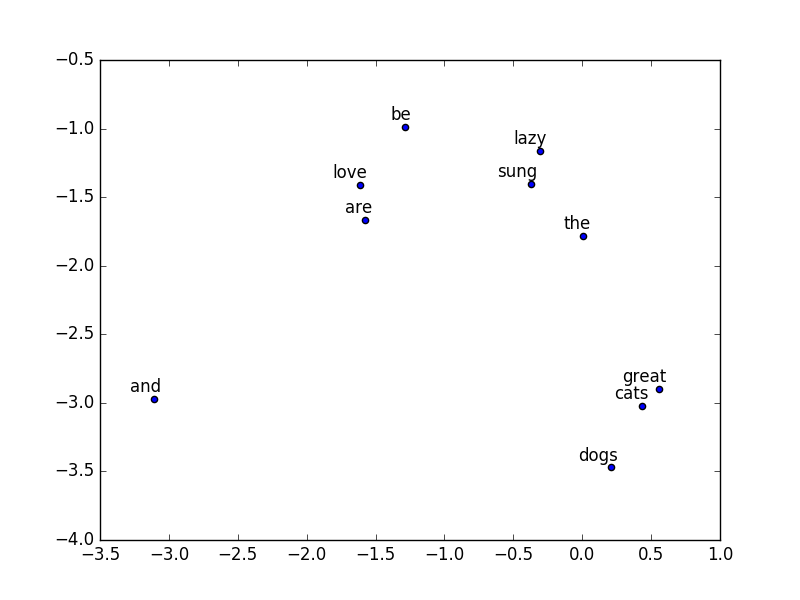

In [2]:
# Example: word2vec
#example of simple feedforward network using tensorflow
#adapted from https://github.com/nlintz/TensorFlow-Tutorials
# Inspired by https://www.tensorflow.org/versions/r0.7/tutorials/word2vec/index.html
import collections
import numpy as np
import tensorflow as tf
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

# Configuration
batch_size = 20
# Dimension of the embedding vector. Two too small to get
# any meaningful embeddings, but let's make it 2 for simple visualization
embedding_size = 2
num_sampled = 15    # Number of negative examples to sample.

# Sample sentences
sentences = ["the quick brown fox jumped over the lazy dog",
            "I love cats and dogs",
            "we all love cats and dogs",
            "cats and dogs are great",
            "sung likes cats",
            "she loves dogs",
            "cats can be very independent",
            "cats are great companions when they want to be",
            "cats are playful",
            "cats are natural hunters",
            "It's raining cats and dogs",
            "dogs and cats love sung"]

# sentences to words and count
words = " ".join(sentences).split()
count = collections.Counter(words).most_common()
print ("Word count", count[:5])

# Build dictionaries
rdic = [i[0] for i in count] #reverse dic, idx -> word
dic = {w: i for i, w in enumerate(rdic)} #dic, word -> id
voc_size = len(dic)

# Make indexed word data
data = [dic[word] for word in words]
print('Sample data', data[:10], [rdic[t] for t in data[:10]])

# Let's make a training data for window size 1 for simplicity
# ([the, brown], quick), ([quick, fox], brown), ([brown, jumped], fox), ...
cbow_pairs = [];
for i in range(1, len(data)-1) :
    cbow_pairs.append([[data[i-1], data[i+1]], data[i]]);
print('Context pairs', cbow_pairs[:10])

# Let's make skip-gram pairs
# (quick, the), (quick, brown), (brown, quick), (brown, fox), ...
skip_gram_pairs = [];
for c in cbow_pairs:
    skip_gram_pairs.append([c[1], c[0][0]])
    skip_gram_pairs.append([c[1], c[0][1]])
print('skip-gram pairs', skip_gram_pairs[:5])

def generate_batch(size):
    assert size < len(skip_gram_pairs)
    x_data=[]
    y_data = []
    r = np.random.choice(range(len(skip_gram_pairs)), size, replace=False)
    for i in r:
        x_data.append(skip_gram_pairs[i][0])  # n dim
        y_data.append([skip_gram_pairs[i][1]])  # n, 1 dim
    return x_data, y_data

# generate_batch test
print ('Batches (x, y)', generate_batch(3))

# Input data
train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
# need to shape [batch_size, 1] for nn.nce_loss
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
# Ops and variables pinned to the CPU because of missing GPU implementation
with tf.device('/cpu:0'):
    # Look up embeddings for inputs.
    embeddings = tf.Variable(
        tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs) # lookup table

# Construct the variables for the NCE loss
nce_weights = tf.Variable(
    tf.random_uniform([voc_size, embedding_size],-1.0, 1.0))
nce_biases = tf.Variable(tf.zeros([voc_size]))

# Compute the average NCE loss for the batch.
# This does the magic:
#   tf.nn.nce_loss(weights, biases, inputs, labels, num_sampled, num_classes ...)
# It automatically draws negative samples when we evaluate the loss.
loss = tf.reduce_mean(
  tf.nn.nce_loss(nce_weights, nce_biases, embed, train_labels,
                 num_sampled, voc_size))

# Use the adam optimizer
train_op = tf.train.AdamOptimizer(1e-1).minimize(loss)

# Launch the graph in a session
with tf.Session() as sess:
    # Initializing all variables
    tf.initialize_all_variables().run()

    for step in range(100):
        batch_inputs, batch_labels = generate_batch(batch_size)
        _, loss_val = sess.run([train_op, loss],
                feed_dict={train_inputs: batch_inputs, train_labels: batch_labels})
        if step % 10 == 0:
          print("Loss at ", step, loss_val) # Report the loss

    # Final embeddings are ready for you to use. Need to normalize for practical use
    trained_embeddings = embeddings.eval()

# Show word2vec if dim is 2
if trained_embeddings.shape[1] == 2:
    labels = rdic[:10] # Show top 10 words
    for i, label in enumerate(labels):
        x, y = trained_embeddings[i,:]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2),
            textcoords='offset points', ha='right', va='bottom')
    plt.savefig("images/word2vec.png")
Image(filename='images/word2vec.png')

In [6]:
#Example: MNIST task
#example of simple feedforward network using tensorflow
#adapted from https://github.com/nlintz/TensorFlow-Tutorials
import tensorflow as tf
import numpy as np
import input_data

def init_weights(shape):
    return tf.Variable(tf.random_normal(shape, stddev=0.01))

def model(X, w_h, w_o):
    h = tf.nn.sigmoid(tf.matmul(X, w_h)) # this is a basic mlp, think 2 stacked logistic regressions
    return tf.matmul(h, w_o) # note that we dont take the softmax at the end because our cost fn does that for us

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

X = tf.placeholder("float", [None, 784])
Y = tf.placeholder("float", [None, 10])

w_h = init_weights([784, 625]) # create symbolic variables
w_o = init_weights([625, 10])

py_x = model(X, w_h, w_o)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(py_x, Y)) # compute costs
train_op = tf.train.GradientDescentOptimizer(0.05).minimize(cost) # construct an optimizer
predict_op = tf.argmax(py_x, 1)

# Launch the graph in a session
with tf.Session() as sess:
    # you need to initialize all variables
    tf.initialize_all_variables().run()

    for i in range(10):
        for start, end in zip(range(0, len(trX), 128), range(128, len(trX)+1, 128)):
            sess.run(train_op, feed_dict={X: trX[start:end], Y: trY[start:end]})
        print(i, np.mean(np.argmax(teY, axis=1) ==
                         sess.run(predict_op, feed_dict={X: teX, Y: teY})))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/gzip.py:274: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  return self._buffer.read(size)
/Users/arminouri/SourceTree/Cognitive-Computing/ToolKit/DeepLearning/Overview/input_data.py:42: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  data = data.reshape(num_images, rows, cols, 1)


Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
0 0.691
1 0.8262
2 0.8626
3 0.8803
4 0.8881
5 0.8942
6 0.8978
7 0.9006
8 0.904
9 0.9058


### Recursive Neural Network###
Suppose you need to train a network to classify sentences for their sentiment. You can potentially train word2vec on individual words, then try to use some composition functions to guess the sentiment of the sentences based on the aggregation of word vectors. This does not yield very good results, since sentiment is a subtle concept and often depends on complicated features such as ordering, negation, etc. Moreover the syntactic relationship between words often plays a big role in sentiment.

Suppose you have the binary syntax tree of a sentence and would like to use it to predict its sentiment. One possible way is to use Recursive NNs. Recursive NNs simply traverse the syntax tree of the sentence in a recursive manner. At each node in the tree, the network calculates two values: the predicted sentiment of that node (using a softmax classifier), and the 'carry-over' value of the node (using a non-linearity function). The image below demonstrates this process for the simple phrase: *not very good.*

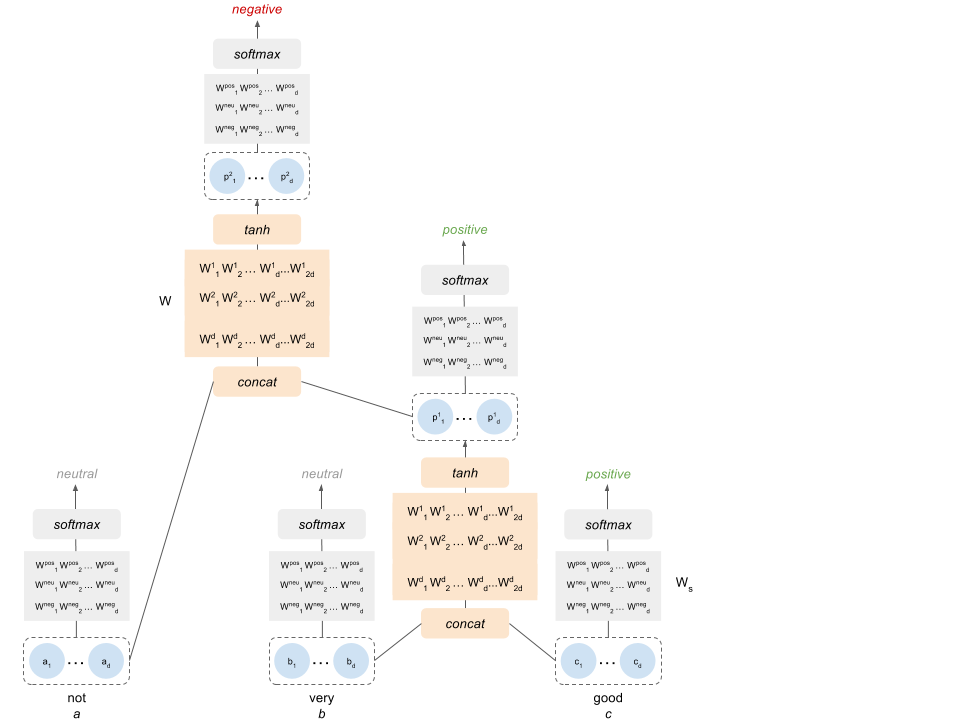

In [2]:
Image(filename='images/recnn.png')

A problem with vanilla RecNNs is that they apply a non-linearity at every level of recursion. But sometimes the relationship between adjacent words is a very simple one, for instane 'very good' is the same as 'good,' but with a stronger emphasis on sentiment, or 'not good' is the same as 'good,' but with the sentiment reversed. To capture these linear relationships, we can use **Matrix-Vector RecNNs (MV-RecNNs)**. In these networds, each node is represented by two indicators:

* A d-dimenstional vector, as before.
* A dxd dimensional matrix, which captures the relationship between the vector of the given word, and the vector of its adjacent word.

The image below illustrates how the network operates in this mode.

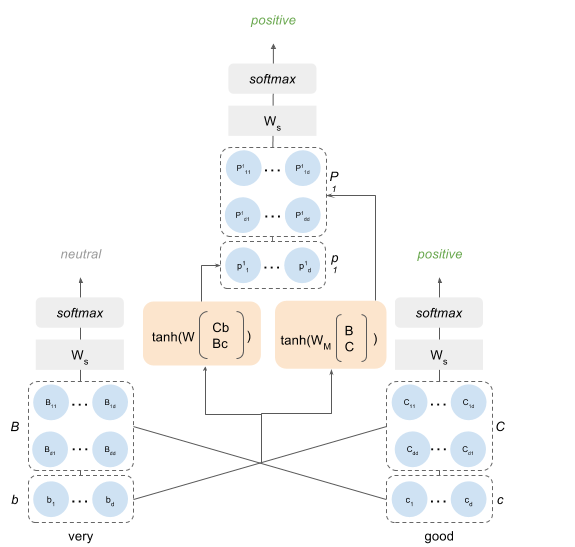

In [3]:
Image(filename='images/mvrecnn.png')

The main disadvantage of MV-RecNN is the enormity of the number of its parameters. Each word has to learn a d-dimensional vector as well as a dxd-dimensional matrix, which requires very large amounts of training data to converge properly. 

A possible way to address this problem is to reduce the number of parameters by representing linear intra-word relationships with one global matrix. To do this, we define a Tensor of order 3, with dimensions 2dx2dxd. This tensor captures the relationships between all pairs of words in the training set. This model is known as a **Recursive Neural Tensor Network (RNTN)**. 

In this network, the words are presented using d-dimensional vectors as before, but recursive non-linearity is applied as follows:
$$p^1=tanh(\begin{bmatrix}b\\c\end{bmatrix}^TV^{[1:d]}\begin{bmatrix}b\\c\end{bmatrix}+W\begin{bmatrix}b\\c\end{bmatrix}),$$
$$p^2=tanh(\begin{bmatrix}a\\p^1\end{bmatrix}^TV^{[1:d]}\begin{bmatrix}a\\p^1\end{bmatrix}+W\begin{bmatrix}a\\p^1\end{bmatrix})$$

where $V$ is the tensor. The figure below shows how the vector for $p^1$ will be calculated.

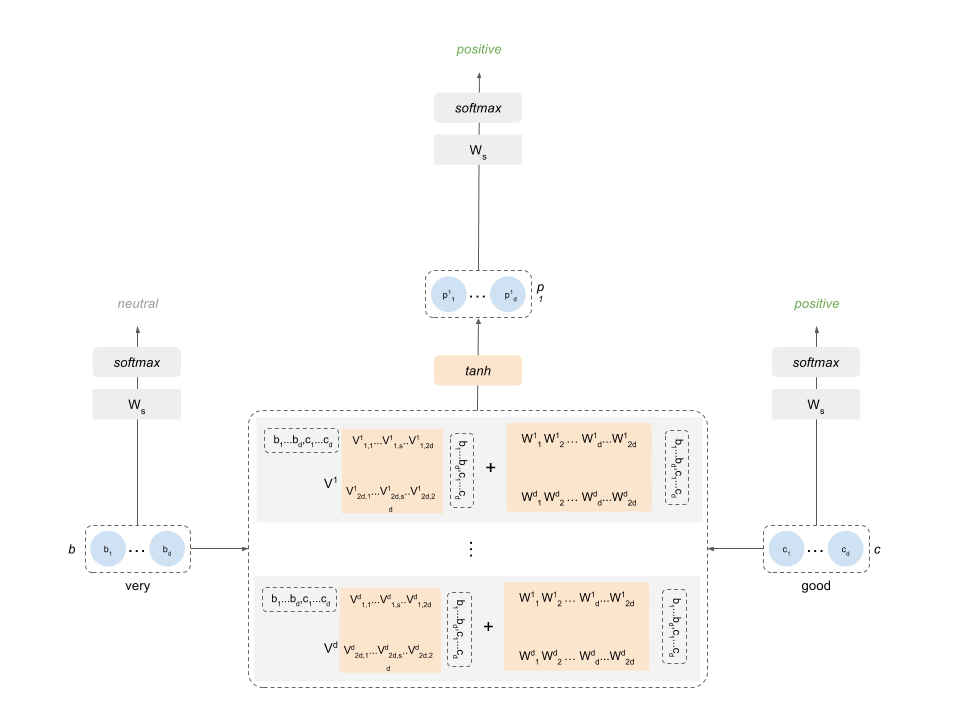

In [5]:
Image(filename='images/rntn.png')

### Recurrent Neural Networks ###
Recurrent Neural Networks or RNNs are a special type of Recursive Neural Network, where:
* The 'tree' is a chain of words, i.e. each parent has a single child.
* The chain does not represent a syntatic tree, but a sequence of words as they are encountered in a sentence/doc.
* The chain is not (necessarily) limited to a single sentence. It can span an entire paragraph or document.

The idea behind RNNs is to allow the network to model arbitrarily long sequences of words. In each step or time $t$, the hidden state is updated using the current input and the previous hidden state (see Figure below).

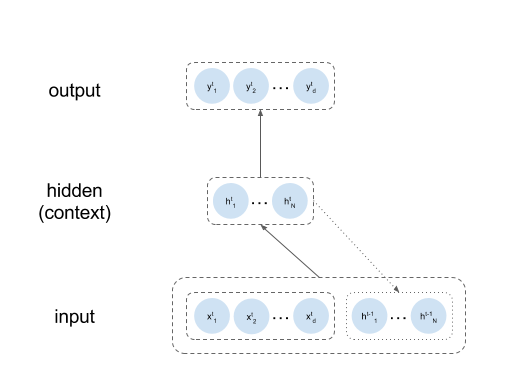

In [5]:
Image(filename='images/rnn.png')

RNNs are very useful in capturing long-term dependencies in arbirtrarily long sequences, but they suffer from the problem of *unstable gradients.* In order to demonstrate this problem, let's consider the example of a simple feedforward network with three hidden layers. Suppose we're using the sigmoid function for non-linearity. Also suppose:
* $\sigma$ represents the sigmoid function.
* $\sigma'$ represents the derivative of the sigmoid function.
* $z$ represents the affine transformation between layers.
The figure below shows what happens during backpropagation. 

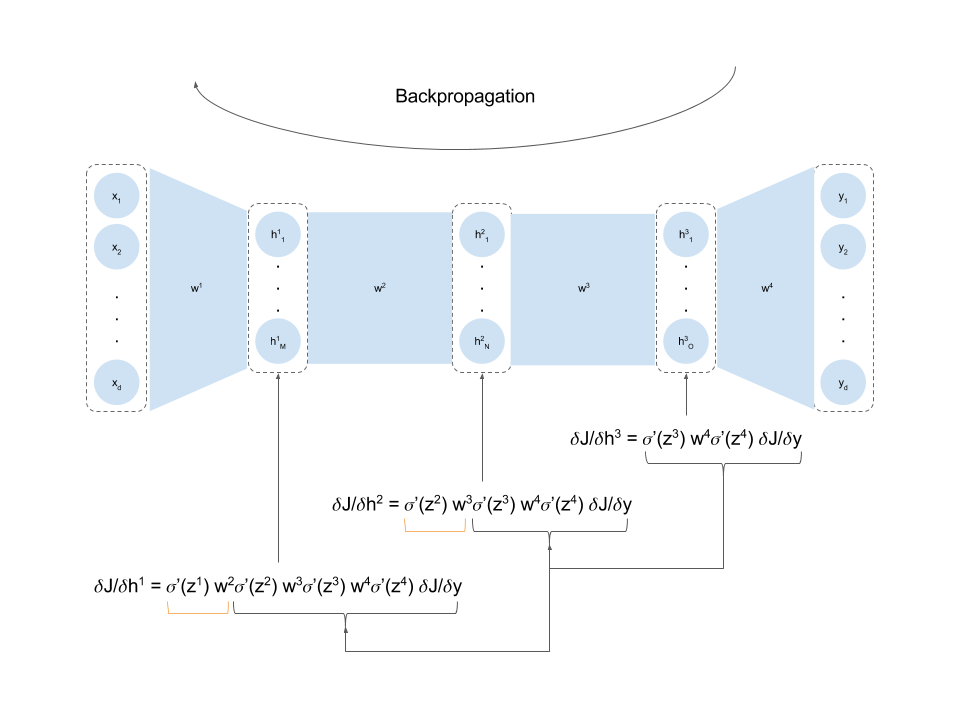

In [4]:
Image(filename='images/gradients.png')

As you can see, the gradient of each layer has a carry-over term from the previous layer (identified by the grey curly brackets) multiplied by a term (identified by the orange square brackets). The multiplier is in the form $\sigma'(z^i)w^j$. Now consider the following:
* The derivative of the sigmoid function ($\sigma$) is always between 0 and 1/4.
* $w^i$s are often initiated using a uniform randomaizer between 0 and 1.
This means that multiplying the two values will give a value below 1/4. At every step of backpropagation, the values of gradients are being reduced to less than 0.25%. This can quickly lead to the problem is **vanishing gradients.**

In contrast, if $w^i$s are initiated to values that are larger than 1, or if the nonlinearity is a function whose derivative boosts the magnitude of $w^i$s, then the problem of **exploding gradients** occurs.

This is particularly problematic for RNNs, because their depth can be arbitrarily large. Moreover, sometimes it's unhelpful or misleading to drag gradients over potentially unlimited distances, since sometimes a sequence of words needs to be 'reset' semantically (think of it as a beginning on a new semantic 'paragraph'). One way to address this issue is to use **Gated Recurrent Neural Units (GRUs).**

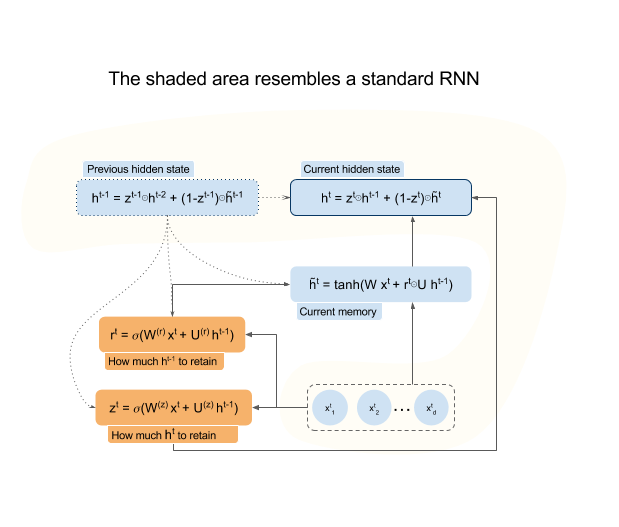

In [9]:
Image(filename='images/gru.png')

GRUs make use of two 'gates,' which are vectors that can work like filters:
* The **reset gate ($r$)** handles how much of the previous hidden state can seep through to the current memory.
* The **update gate ($z$)** handles how much of the current memory can be memorized.

The elementwise multiplication operation allows the gates to pick how much of each dimension they allow through. 
Note how the update gate is not subject to multiplication by non-linearity, thus it helps alleviate the problem of vanishing gradients.
### Long Short Term Memory (LSTM) ###
LSTMs operate very similarly to GRUs, except they pack the 'update' gate into two independently trained gates *forget* and *output*:
* The **input gate ($i$)** determines how much of the new input can get to the current memory. This gate can be renamed to **memorize** or **observe** or **take in.**
* The **forget gate ($f$)** determines how much of the previous hidden state should be forgotten.
* The **output gate ($o$)** determines how much of the current memory can be carried over to the output. This gate can be renamed to **remember** or **express.**

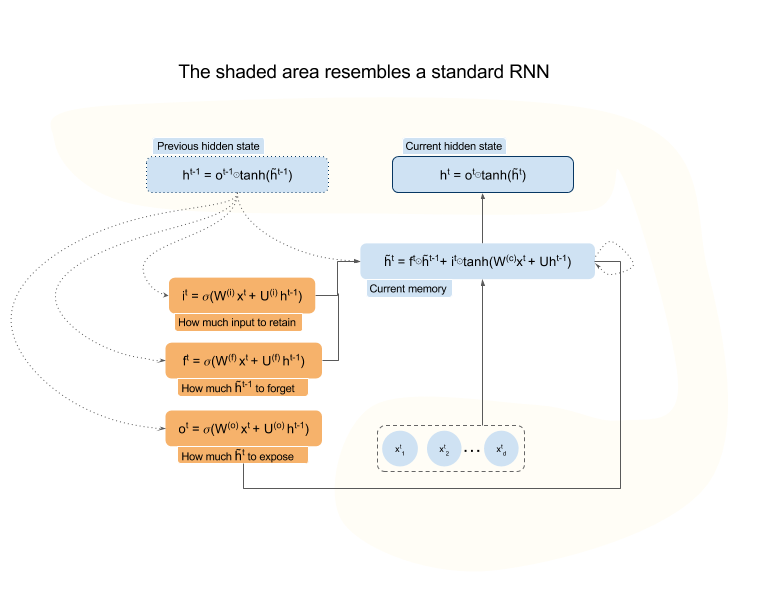

In [10]:
Image(filename='images/lstm.png')

In [1]:
# Example: MNIST  task
#example of LSTM using tensorflow
#adapted from https://github.com/nlintz/TensorFlow-Tutorials
#Inspired by https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3%20-%20Neural%20Networks/recurrent_network.py
import tensorflow as tf

import numpy as np
import input_data

# configuration
#                        O * W + b -> 10 labels for each image, O[? 28], W[28 10], B[10]
#                       ^ (O: output 28 vec from 28 vec input)
#                       |
#      +-+  +-+       +--+
#      |1|->|2|-> ... |28| time_step_size = 28
#      +-+  +-+       +--+
#       ^    ^    ...  ^
#       |    |         |
# img1:[28] [28]  ... [28]
# img2:[28] [28]  ... [28]
# img3:[28] [28]  ... [28]
# ...
# img128 or img256 (batch_size or test_size 256)
#      each input size = input_vec_size=lstm_size=28

# configuration variables
input_vec_size = lstm_size = 28
time_step_size = 28

batch_size = 128
test_size = 256

def init_weights(shape):
    return tf.Variable(tf.random_normal(shape, stddev=0.01))


def model(X, W, B, lstm_size):
    # X, input shape: (batch_size, time_step_size, input_vec_size)
    XT = tf.transpose(X, [1, 0, 2])  # permute time_step_size and batch_size
    # XT shape: (time_step_size, batch_size, input_vec_size)
    XR = tf.reshape(XT, [-1, lstm_size]) # each row has input for each lstm cell (lstm_size=input_vec_size)
    # XR shape: (time_step_size * batch_size, input_vec_size)
    X_split = tf.split(0, time_step_size, XR) # split them to time_step_size (28 arrays)
    # Each array shape: (batch_size, input_vec_size)

    # Make lstm with lstm_size (each input vector size)
    lstm = tf.nn.rnn_cell.BasicLSTMCell(lstm_size, forget_bias=1.0, state_is_tuple=True)

    # Get lstm cell output, time_step_size (28) arrays with lstm_size output: (batch_size, lstm_size)
    outputs, _states = tf.nn.rnn(lstm, X_split, dtype=tf.float32)

    # Linear activation
    # Get the last output
    return tf.matmul(outputs[-1], W) + B, lstm.state_size # State size to initialize the stat

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels
trX = trX.reshape(-1, 28, 28)
teX = teX.reshape(-1, 28, 28)

X = tf.placeholder("float", [None, 28, 28])
Y = tf.placeholder("float", [None, 10])

# get lstm_size and output 10 labels
W = init_weights([lstm_size, 10])
B = init_weights([10])

py_x, state_size = model(X, W, B, lstm_size)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(py_x, Y))
train_op = tf.train.RMSPropOptimizer(0.001, 0.9).minimize(cost)
predict_op = tf.argmax(py_x, 1)

# Launch the graph in a session
with tf.Session() as sess:
    # you need to initialize all variables
    tf.initialize_all_variables().run()

    for i in range(10):
        for start, end in zip(range(0, len(trX), batch_size), range(batch_size, len(trX)+1, batch_size)):
            sess.run(train_op, feed_dict={X: trX[start:end], Y: trY[start:end]})

        test_indices = np.arange(len(teX))  # Get A Test Batch
        np.random.shuffle(test_indices)
        test_indices = test_indices[0:test_size]

        print(i, np.mean(np.argmax(teY[test_indices], axis=1) ==
                         sess.run(predict_op, feed_dict={X: teX[test_indices],
                                                         Y: teY[test_indices]})))

Succesfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/gzip.py:274: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  return self._buffer.read(size)
/Users/u6026978/SourceTree/Cognitive-Computing/ToolKit/DeepLearning/Overview/input_data.py:42: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  data = data.reshape(num_images, rows, cols, 1)


Succesfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Succesfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Succesfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
0 0.671875
1 0.859375
2 0.90234375
3 0.9296875
4 0.9609375
5 0.94921875
6 0.96484375
7 0.953125
8 0.9609375
9 0.96875


### Convolutional Neural Networks (CNNs) ###
So far, we've tried to devise networks that allow modeling of arbitrarily long sequences. But in many NLP applications it's more desirable to entirely skip parts of the sequence that are irrelevant. Consider the sentece: "The **movie**, starring Jimmy Stewart and directed by Syndey Lumet, **was superb**.
If we were to classify the sentence according to its sentiment, it would be helpful to have a mechanism that helps the network ignore the parts that are not relevant to sentiment. 

* Recursive RNNs help alleviate this problem by leveraging the syntax tree of the sentence, but what if such trees are not available or not accurate?
* Recurrent Neural Nets don't require a parser but they have a one-directional (or two-directional) orientation and often undermine important phrases that occur in the beginning or middle of a sequence through subsequent gradient updates.

**Convolutional Neural Networks** try to tackle this issue by attacking the sequence from *all angles,* i.e. instead of looking at it from left to right or bottom to top, they scan all possible continuous subsequences and aggregate their vectors. They do this by running the sequence through a fixed size convolution, where a moving window is applied to various parts of the sequence. Such that for a window of size 3, the sentence above is transformed into:
* The movie starring
* movie starring Jimmy
* starring Jimmy Stewart
* Jimmy Stewart and
* Stewart and directed
* and directed by
* ...
* Lumet was superb.

Since these windows can get large in number pretty quickly, every once in a while the network applies a *Max-k pooling* strategy that picks the windows with the highest values. For instance, if $k=2$, then the network might decide that the top two sequences to pay attention to are *The movie starring* and *Lumet was superb.*

Finally, the network might decide that some dimensions can be *folded* into each other to give more 'meat' to the semantics.

The image below, adapted from [Kalchbrenner et al.](http://www.aclweb.org/anthology/P14-1062) shows a CNN with multiple convolutional, pooling and folding layers.


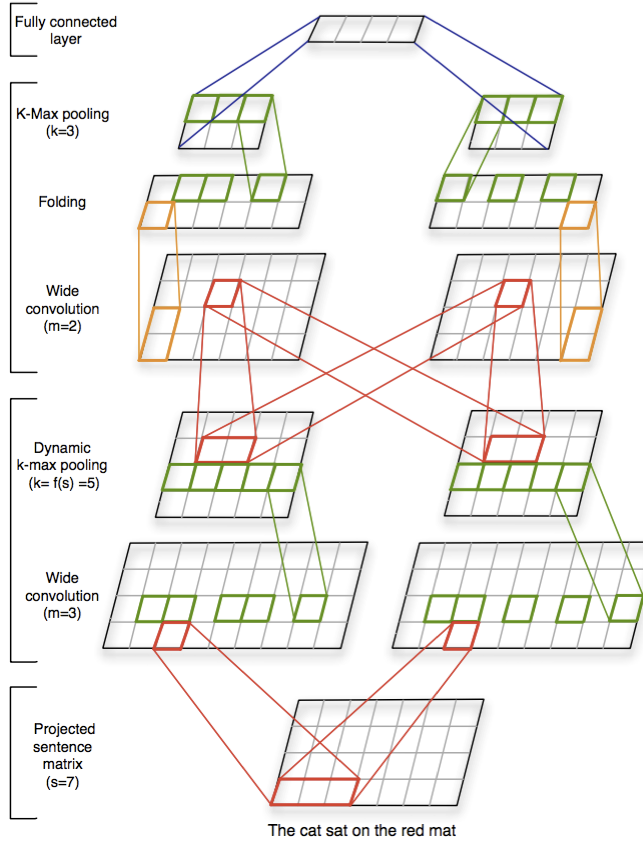

In [11]:
Image(filename='images/cnn.png')

In [2]:
#!/usr/bin/env python
# Example: MNIST  task
#example of CNN using tensorflow
#adapted from https://github.com/nlintz/TensorFlow-Tutorials
import tensorflow as tf
import numpy as np
import input_data

batch_size = 128
test_size = 256

def init_weights(shape):
    return tf.Variable(tf.random_normal(shape, stddev=0.01))


def model(X, w, w2, w3, w4, w_o, p_keep_conv, p_keep_hidden):
    l1a = tf.nn.relu(tf.nn.conv2d(X, w,                       # l1a shape=(?, 28, 28, 32)
                        strides=[1, 1, 1, 1], padding='SAME'))
    l1 = tf.nn.max_pool(l1a, ksize=[1, 2, 2, 1],              # l1 shape=(?, 14, 14, 32)
                        strides=[1, 2, 2, 1], padding='SAME')
    l1 = tf.nn.dropout(l1, p_keep_conv)

    l2a = tf.nn.relu(tf.nn.conv2d(l1, w2,                     # l2a shape=(?, 14, 14, 64)
                        strides=[1, 1, 1, 1], padding='SAME'))
    l2 = tf.nn.max_pool(l2a, ksize=[1, 2, 2, 1],              # l2 shape=(?, 7, 7, 64)
                        strides=[1, 2, 2, 1], padding='SAME')
    l2 = tf.nn.dropout(l2, p_keep_conv)

    l3a = tf.nn.relu(tf.nn.conv2d(l2, w3,                     # l3a shape=(?, 7, 7, 128)
                        strides=[1, 1, 1, 1], padding='SAME'))
    l3 = tf.nn.max_pool(l3a, ksize=[1, 2, 2, 1],              # l3 shape=(?, 4, 4, 128)
                        strides=[1, 2, 2, 1], padding='SAME')
    l3 = tf.reshape(l3, [-1, w4.get_shape().as_list()[0]])    # reshape to (?, 2048)
    l3 = tf.nn.dropout(l3, p_keep_conv)

    l4 = tf.nn.relu(tf.matmul(l3, w4))
    l4 = tf.nn.dropout(l4, p_keep_hidden)

    pyx = tf.matmul(l4, w_o)
    return pyx

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels
trX = trX.reshape(-1, 28, 28, 1)  # 28x28x1 input img
teX = teX.reshape(-1, 28, 28, 1)  # 28x28x1 input img

X = tf.placeholder("float", [None, 28, 28, 1])
Y = tf.placeholder("float", [None, 10])

w = init_weights([3, 3, 1, 32])       # 3x3x1 conv, 32 outputs
w2 = init_weights([3, 3, 32, 64])     # 3x3x32 conv, 64 outputs
w3 = init_weights([3, 3, 64, 128])    # 3x3x32 conv, 128 outputs
w4 = init_weights([128 * 4 * 4, 625]) # FC 128 * 4 * 4 inputs, 625 outputs
w_o = init_weights([625, 10])         # FC 625 inputs, 10 outputs (labels)

p_keep_conv = tf.placeholder("float")
p_keep_hidden = tf.placeholder("float")
py_x = model(X, w, w2, w3, w4, w_o, p_keep_conv, p_keep_hidden)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(py_x, Y))
train_op = tf.train.RMSPropOptimizer(0.001, 0.9).minimize(cost)
predict_op = tf.argmax(py_x, 1)

# Launch the graph in a session
with tf.Session() as sess:
    # you need to initialize all variables
    tf.initialize_all_variables().run()

    for i in range(10):
        training_batch = zip(range(0, len(trX), batch_size),
                             range(batch_size, len(trX)+1, batch_size))
        for start, end in training_batch:
            sess.run(train_op, feed_dict={X: trX[start:end], Y: trY[start:end],
                                          p_keep_conv: 0.8, p_keep_hidden: 0.5})

        test_indices = np.arange(len(teX)) # Get A Test Batch
        np.random.shuffle(test_indices)
        test_indices = test_indices[0:test_size]

        print(i, np.mean(np.argmax(teY[test_indices], axis=1) ==
                         sess.run(predict_op, feed_dict={X: teX[test_indices],
                                                         Y: teY[test_indices],
                                                         p_keep_conv: 1.0,
                                                         p_keep_hidden: 1.0})))

Extracting MNIST_data/train-images-idx3-ubyte.gz


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/gzip.py:274: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  return self._buffer.read(size)
/Users/u6026978/SourceTree/Cognitive-Computing/ToolKit/DeepLearning/Overview/input_data.py:42: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  data = data.reshape(num_images, rows, cols, 1)


Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
0 0.92578125
1 0.98046875
2 0.98046875
3 0.984375
4 0.984375
5 0.99609375
6 0.98828125
7 0.9921875
8 0.99609375
9 0.9921875
